<a href="https://colab.research.google.com/github/motameni/gen-ai/blob/main/a_persian_customer_support_agent_openai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Setup

In [ ]:
import os

from google.colab import userdata

os.environ['HUGGINGFACE_CLI_TOKEN'] = userdata.get('HUGGINGFACE_CLI_TOKEN')

os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_API_KEY'] = userdata.get('LANGCHAIN_API_KEY')

os.environ['TAVILY_API_KEY'] = userdata.get('TAVILY_API_KEY')

os.environ['ANTHROPIC_API_KEY'] = userdata.get('ANTHROPIC_API_KEY')
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')

In [ ]:
!huggingface-cli login --token "$HUGGINGFACE_CLI_TOKEN"

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
!pip install -U langchain langchain_community langchainhub tiktoken chromadb tavily-python pandas
!pip install -U langgraph
!pip install -U transformers
!pip install -U bitsandbytes accelerate
!pip install -U sentence-transformers
!pip install -U langchain-anthropic
!pip install -U langchain-openai
!pip install -U optimum
!pip install -U auto-gptq

In [ ]:
# import torch
# from transformers import BitsAndBytesConfig, AutoModel, AutoModelForCausalLM, AutoTokenizer, pipeline

# quantization_config = BitsAndBytesConfig(
#     load_in_4bit=True,
#     bnb_4bit_compute_dtype=torch.float16,
#     bnb_4bit_quant_type="nf4",
#     bnb_4bit_use_double_quant=True,
# )

# # device = "cuda" # the device to load the model onto

# model_id = "NousResearch/Meta-Llama-3-8B-Instruct"
# # model_id = "mobiuslabsgmbh/Mixtral-8x7B-Instruct-v0.1-hf-attn-4bit-moe-2bit-HQQ"

# tokenizer = AutoTokenizer.from_pretrained(model_id)
# model = AutoModelForCausalLM.from_pretrained(model_id, quantization_config=quantization_config)

In [ ]:
# from langchain_community.llms.huggingface_pipeline import HuggingFacePipeline

# pipe = pipeline("text-generation",
#                 model=model,
#                 tokenizer=tokenizer,
#                 max_new_tokens=1000,
# )

# llm = HuggingFacePipeline(pipeline=pipe)

# Load Translator Model

In [ ]:
from transformers import AutoTokenizer, pipeline
from langchain_community.llms.huggingface_pipeline import HuggingFacePipeline


model_id = "astronomer/Llama-3-8B-Instruct-GPTQ-4-Bit"

tokenizer = AutoTokenizer.from_pretrained(model_id)

terminators = [
    tokenizer.eos_token_id,
    tokenizer.convert_tokens_to_ids("<|eot_id|>")
]


# model = AutoModelForCausalLM.from_pretrained(model_id, device_map="cpu")

hf_pipeline = pipeline(
    "text-generation",
    model=model_id,
    device_map="cuda",
    tokenizer=tokenizer,
    max_new_tokens=256,
    eos_token_id=terminators,
    return_full_text=False,
    do_sample=True,
    temperature=0.6,
    top_p=0.9,
    # disable_exllama=True
)

llm = HuggingFacePipeline(pipeline=hf_pipeline)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/5.74G [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:4371: FutureWarning: `_is_quantized_training_enabled` is going to be deprecated in transformers 4.39.0. Please use `model.hf_quantizer.is_trainable` instead
  warnings.warn(
The cos_cached attribute will be removed in 4.39. Bear in mind that its contents changed in v4.38. Use the forward method of RoPE from now on instead. It is not used in the `LlamaAttention` class
The sin_cached attribute will be removed in 4.39. Bear in mind that its contents changed in v4.38. Use the forward method of RoPE from now on instead. It is not used in the `LlamaAttention` class


generation_config.json:   0%|          | 0.00/136 [00:00<?, ?B/s]

# Populate the database

In [ ]:
# Populate the database

import os
import shutil
import sqlite3

import pandas as pd
import requests

db_url = "https://storage.googleapis.com/benchmarks-artifacts/travel-db/travel2.sqlite"
local_file = "travel2.sqlite"
# The backup lets us restart for each tutorial section
backup_file = "travel2.backup.sqlite"
overwrite = False
if overwrite or not os.path.exists(local_file):
    response = requests.get(db_url)
    response.raise_for_status()  # Ensure the request was successful
    with open(local_file, "wb") as f:
        f.write(response.content)
    # Backup - we will use this to "reset" our DB in each section
    shutil.copy(local_file, backup_file)
# Convert the flights to present time for our tutorial
conn = sqlite3.connect(local_file)
cursor = conn.cursor()

tables = pd.read_sql(
    "SELECT name FROM sqlite_master WHERE type='table';", conn
).name.tolist()
tdf = {}
for t in tables:
    tdf[t] = pd.read_sql(f"SELECT * from {t}", conn)

example_time = pd.to_datetime(
    tdf["flights"]["actual_departure"].replace("\\N", pd.NaT)
).max()
current_time = pd.to_datetime("now").tz_localize(example_time.tz)
time_diff = current_time - example_time

tdf["bookings"]["book_date"] = (
    pd.to_datetime(tdf["bookings"]["book_date"].replace("\\N", pd.NaT), utc=True)
    + time_diff
)

datetime_columns = [
    "scheduled_departure",
    "scheduled_arrival",
    "actual_departure",
    "actual_arrival",
]
for column in datetime_columns:
    tdf["flights"][column] = (
        pd.to_datetime(tdf["flights"][column].replace("\\N", pd.NaT)) + time_diff
    )

for table_name, df in tdf.items():
    df.to_sql(table_name, conn, if_exists="replace", index=False)
del df
del tdf
conn.commit()
conn.close()

db = local_file  # We'll be using this local file as our DB in this tutorial

# Tools

## Lookup Company Policies


In [ ]:

import re

import numpy as np
import openai
from langchain_core.tools import tool

response = requests.get(
    "https://storage.googleapis.com/benchmarks-artifacts/travel-db/swiss_faq.md"
)
response.raise_for_status()
faq_text = response.text

docs = [{"page_content": txt} for txt in re.split(r"(?=\n##)", faq_text)]


class VectorStoreRetriever:
    def __init__(self, docs: list, vectors: list, oai_client):
        self._arr = np.array(vectors)
        self._docs = docs
        self._client = oai_client

    @classmethod
    def from_docs(cls, docs, oai_client):
        embeddings = oai_client.embeddings.create(
            model="text-embedding-3-small", input=[doc["page_content"] for doc in docs]
        )
        vectors = [emb.embedding for emb in embeddings.data]
        return cls(docs, vectors, oai_client)

    def query(self, query: str, k: int = 5) -> list[dict]:
        embed = self._client.embeddings.create(
            model="text-embedding-3-small", input=[query]
        )
        # "@" is just a matrix multiplication in python
        scores = np.array(embed.data[0].embedding) @ self._arr.T
        top_k_idx = np.argpartition(scores, -k)[-k:]
        top_k_idx_sorted = top_k_idx[np.argsort(-scores[top_k_idx])]
        return [
            {**self._docs[idx], "similarity": scores[idx]} for idx in top_k_idx_sorted
        ]


retriever = VectorStoreRetriever.from_docs(docs, openai.Client())


@tool
def lookup_policy(query: str) -> str:
    """Consult the company policies to check whether certain options are permitted.
    Use this before making any flight changes performing other 'write' events."""
    docs = retriever.query(query, k=2)
    return "\n\n".join([doc["page_content"] for doc in docs])

## Flights


In [ ]:

import sqlite3
from datetime import date, datetime, timedelta
from typing import Optional

import pytz
from langchain_core.runnables import ensure_config


@tool
def fetch_user_flight_information() -> list[dict]:
    """Fetch all tickets for the user along with corresponding flight information and seat assignments.

    Returns:
        A list of dictionaries where each dictionary contains the ticket details,
        associated flight details, and the seat assignments for each ticket belonging to the user.
    """
    config = ensure_config()  # Fetch from the context
    configuration = config.get("configurable", {})
    passenger_id = configuration.get("passenger_id", None)
    if not passenger_id:
        raise ValueError("No passenger ID configured.")

    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    query = """
    SELECT
        t.ticket_no, t.book_ref,
        f.flight_id, f.flight_no, f.departure_airport, f.arrival_airport, f.scheduled_departure, f.scheduled_arrival,
        bp.seat_no, tf.fare_conditions
    FROM
        tickets t
        JOIN ticket_flights tf ON t.ticket_no = tf.ticket_no
        JOIN flights f ON tf.flight_id = f.flight_id
        JOIN boarding_passes bp ON bp.ticket_no = t.ticket_no AND bp.flight_id = f.flight_id
    WHERE
        t.passenger_id = ?
    """
    cursor.execute(query, (passenger_id,))
    rows = cursor.fetchall()
    column_names = [column[0] for column in cursor.description]
    results = [dict(zip(column_names, row)) for row in rows]

    cursor.close()
    conn.close()

    return results


@tool
def search_flights(
    departure_airport: Optional[str] = None,
    arrival_airport: Optional[str] = None,
    start_time: Optional[date | datetime] = None,
    end_time: Optional[date | datetime] = None,
    limit: int = 20,
) -> list[dict]:
    """Search for flights based on departure airport, arrival airport, and departure time range."""
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    query = "SELECT * FROM flights WHERE 1 = 1"
    params = []

    if departure_airport:
        query += " AND departure_airport = ?"
        params.append(departure_airport)

    if arrival_airport:
        query += " AND arrival_airport = ?"
        params.append(arrival_airport)

    if start_time:
        query += " AND scheduled_departure >= ?"
        params.append(start_time)

    if end_time:
        query += " AND scheduled_departure <= ?"
        params.append(end_time)
    query += " LIMIT ?"
    params.append(limit)
    cursor.execute(query, params)
    rows = cursor.fetchall()
    column_names = [column[0] for column in cursor.description]
    results = [dict(zip(column_names, row)) for row in rows]

    cursor.close()
    conn.close()

    return results


@tool
def update_ticket_to_new_flight(ticket_no: str, new_flight_id: int) -> str:
    """Update the user's ticket to a new valid flight."""
    config = ensure_config()
    configuration = config.get("configurable", {})
    passenger_id = configuration.get("passenger_id", None)
    if not passenger_id:
        raise ValueError("No passenger ID configured.")

    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute(
        "SELECT departure_airport, arrival_airport, scheduled_departure FROM flights WHERE flight_id = ?",
        (new_flight_id,),
    )
    new_flight = cursor.fetchone()
    if not new_flight:
        cursor.close()
        conn.close()
        return "Invalid new flight ID provided."
    column_names = [column[0] for column in cursor.description]
    new_flight_dict = dict(zip(column_names, new_flight))
    timezone = pytz.timezone("Etc/GMT-3")
    current_time = datetime.now(tz=timezone)
    departure_time = datetime.strptime(
        new_flight_dict["scheduled_departure"], "%Y-%m-%d %H:%M:%S.%f%z"
    )
    time_until = (departure_time - current_time).total_seconds()
    if time_until < (3 * 3600):
        return f"Not permitted to reschedule to a flight that is less than 3 hours from the current time. Selected flight is at {departure_time}."

    cursor.execute(
        "SELECT flight_id FROM ticket_flights WHERE ticket_no = ?", (ticket_no,)
    )
    current_flight = cursor.fetchone()
    if not current_flight:
        cursor.close()
        conn.close()
        return "No existing ticket found for the given ticket number."

    # Check the signed-in user actually has this ticket
    cursor.execute(
        "SELECT * FROM tickets WHERE ticket_no = ? AND passenger_id = ?",
        (ticket_no, passenger_id),
    )
    current_ticket = cursor.fetchone()
    if not current_ticket:
        cursor.close()
        conn.close()
        return f"Current signed-in passenger with ID {passenger_id} not the owner of ticket {ticket_no}"

    # In a real application, you'd likely add additional checks here to enforce business logic,
    # like "does the new departure airport match the current ticket", etc.
    # While it's best to try to be *proactive* in 'type-hinting' policies to the LLM
    # it's inevitably going to get things wrong, so you **also** need to ensure your
    # API enforces valid behavior
    cursor.execute(
        "UPDATE ticket_flights SET flight_id = ? WHERE ticket_no = ?",
        (new_flight_id, ticket_no),
    )
    conn.commit()

    cursor.close()
    conn.close()
    return "Ticket successfully updated to new flight."


@tool
def cancel_ticket(ticket_no: str) -> str:
    """Cancel the user's ticket and remove it from the database."""
    config = ensure_config()
    configuration = config.get("configurable", {})
    passenger_id = configuration.get("passenger_id", None)
    if not passenger_id:
        raise ValueError("No passenger ID configured.")
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute(
        "SELECT flight_id FROM ticket_flights WHERE ticket_no = ?", (ticket_no,)
    )
    existing_ticket = cursor.fetchone()
    if not existing_ticket:
        cursor.close()
        conn.close()
        return "No existing ticket found for the given ticket number."

    # Check the signed-in user actually has this ticket
    cursor.execute(
        "SELECT flight_id FROM tickets WHERE ticket_no = ? AND passenger_id = ?",
        (ticket_no, passenger_id),
    )
    current_ticket = cursor.fetchone()
    if not current_ticket:
        cursor.close()
        conn.close()
        return f"Current signed-in passenger with ID {passenger_id} not the owner of ticket {ticket_no}"

    cursor.execute("DELETE FROM ticket_flights WHERE ticket_no = ?", (ticket_no,))
    conn.commit()

    cursor.close()
    conn.close()
    return "Ticket successfully cancelled."

## Car Rental Tools


In [ ]:

from datetime import date, datetime
from typing import Optional, Union


@tool
def search_car_rentals(
    location: Optional[str] = None,
    name: Optional[str] = None,
    price_tier: Optional[str] = None,
    start_date: Optional[Union[datetime, date]] = None,
    end_date: Optional[Union[datetime, date]] = None,
) -> list[dict]:
    """
    Search for car rentals based on location, name, price tier, start date, and end date.

    Args:
        location (Optional[str]): The location of the car rental. Defaults to None.
        name (Optional[str]): The name of the car rental company. Defaults to None.
        price_tier (Optional[str]): The price tier of the car rental. Defaults to None.
        start_date (Optional[Union[datetime, date]]): The start date of the car rental. Defaults to None.
        end_date (Optional[Union[datetime, date]]): The end date of the car rental. Defaults to None.

    Returns:
        list[dict]: A list of car rental dictionaries matching the search criteria.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    query = "SELECT * FROM car_rentals WHERE 1=1"
    params = []

    if location:
        query += " AND location LIKE ?"
        params.append(f"%{location}%")
    if name:
        query += " AND name LIKE ?"
        params.append(f"%{name}%")
    # For our tutorial, we will let you match on any dates and price tier.
    # (since our toy dataset doesn't have much data)
    cursor.execute(query, params)
    results = cursor.fetchall()

    conn.close()

    return [
        dict(zip([column[0] for column in cursor.description], row)) for row in results
    ]


@tool
def book_car_rental(rental_id: int) -> str:
    """
    Book a car rental by its ID.

    Args:
        rental_id (int): The ID of the car rental to book.

    Returns:
        str: A message indicating whether the car rental was successfully booked or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute("UPDATE car_rentals SET booked = 1 WHERE id = ?", (rental_id,))
    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Car rental {rental_id} successfully booked."
    else:
        conn.close()
        return f"No car rental found with ID {rental_id}."


@tool
def update_car_rental(
    rental_id: int,
    start_date: Optional[Union[datetime, date]] = None,
    end_date: Optional[Union[datetime, date]] = None,
) -> str:
    """
    Update a car rental's start and end dates by its ID.

    Args:
        rental_id (int): The ID of the car rental to update.
        start_date (Optional[Union[datetime, date]]): The new start date of the car rental. Defaults to None.
        end_date (Optional[Union[datetime, date]]): The new end date of the car rental. Defaults to None.

    Returns:
        str: A message indicating whether the car rental was successfully updated or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    if start_date:
        cursor.execute(
            "UPDATE car_rentals SET start_date = ? WHERE id = ?",
            (start_date, rental_id),
        )
    if end_date:
        cursor.execute(
            "UPDATE car_rentals SET end_date = ? WHERE id = ?", (end_date, rental_id)
        )

    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Car rental {rental_id} successfully updated."
    else:
        conn.close()
        return f"No car rental found with ID {rental_id}."


@tool
def cancel_car_rental(rental_id: int) -> str:
    """
    Cancel a car rental by its ID.

    Args:
        rental_id (int): The ID of the car rental to cancel.

    Returns:
        str: A message indicating whether the car rental was successfully cancelled or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute("UPDATE car_rentals SET booked = 0 WHERE id = ?", (rental_id,))
    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Car rental {rental_id} successfully cancelled."
    else:
        conn.close()
        return f"No car rental found with ID {rental_id}."

## Hotels

In [ ]:

@tool
def search_hotels(
    location: Optional[str] = None,
    name: Optional[str] = None,
    price_tier: Optional[str] = None,
    checkin_date: Optional[Union[datetime, date]] = None,
    checkout_date: Optional[Union[datetime, date]] = None,
) -> list[dict]:
    """
    Search for hotels based on location, name, price tier, check-in date, and check-out date.

    Args:
        location (Optional[str]): The location of the hotel. Defaults to None.
        name (Optional[str]): The name of the hotel. Defaults to None.
        price_tier (Optional[str]): The price tier of the hotel. Defaults to None. Examples: Midscale, Upper Midscale, Upscale, Luxury
        checkin_date (Optional[Union[datetime, date]]): The check-in date of the hotel. Defaults to None.
        checkout_date (Optional[Union[datetime, date]]): The check-out date of the hotel. Defaults to None.

    Returns:
        list[dict]: A list of hotel dictionaries matching the search criteria.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    query = "SELECT * FROM hotels WHERE 1=1"
    params = []

    if location:
        query += " AND location LIKE ?"
        params.append(f"%{location}%")
    if name:
        query += " AND name LIKE ?"
        params.append(f"%{name}%")
    # For the sake of this tutorial, we will let you match on any dates and price tier.
    cursor.execute(query, params)
    results = cursor.fetchall()

    conn.close()

    return [
        dict(zip([column[0] for column in cursor.description], row)) for row in results
    ]


@tool
def book_hotel(hotel_id: int) -> str:
    """
    Book a hotel by its ID.

    Args:
        hotel_id (int): The ID of the hotel to book.

    Returns:
        str: A message indicating whether the hotel was successfully booked or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute("UPDATE hotels SET booked = 1 WHERE id = ?", (hotel_id,))
    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Hotel {hotel_id} successfully booked."
    else:
        conn.close()
        return f"No hotel found with ID {hotel_id}."


@tool
def update_hotel(
    hotel_id: int,
    checkin_date: Optional[Union[datetime, date]] = None,
    checkout_date: Optional[Union[datetime, date]] = None,
) -> str:
    """
    Update a hotel's check-in and check-out dates by its ID.

    Args:
        hotel_id (int): The ID of the hotel to update.
        checkin_date (Optional[Union[datetime, date]]): The new check-in date of the hotel. Defaults to None.
        checkout_date (Optional[Union[datetime, date]]): The new check-out date of the hotel. Defaults to None.

    Returns:
        str: A message indicating whether the hotel was successfully updated or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    if checkin_date:
        cursor.execute(
            "UPDATE hotels SET checkin_date = ? WHERE id = ?", (checkin_date, hotel_id)
        )
    if checkout_date:
        cursor.execute(
            "UPDATE hotels SET checkout_date = ? WHERE id = ?",
            (checkout_date, hotel_id),
        )

    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Hotel {hotel_id} successfully updated."
    else:
        conn.close()
        return f"No hotel found with ID {hotel_id}."


@tool
def cancel_hotel(hotel_id: int) -> str:
    """
    Cancel a hotel by its ID.

    Args:
        hotel_id (int): The ID of the hotel to cancel.

    Returns:
        str: A message indicating whether the hotel was successfully cancelled or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute("UPDATE hotels SET booked = 0 WHERE id = ?", (hotel_id,))
    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Hotel {hotel_id} successfully cancelled."
    else:
        conn.close()
        return f"No hotel found with ID {hotel_id}."

## Excursions

In [ ]:

@tool
def search_trip_recommendations(
    location: Optional[str] = None,
    name: Optional[str] = None,
    keywords: Optional[str] = None,
) -> list[dict]:
    """
    Search for trip recommendations based on location, name, and keywords.

    Args:
        location (Optional[str]): The location of the trip recommendation. Defaults to None.
        name (Optional[str]): The name of the trip recommendation. Defaults to None.
        keywords (Optional[str]): The keywords associated with the trip recommendation. Defaults to None.

    Returns:
        list[dict]: A list of trip recommendation dictionaries matching the search criteria.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    query = "SELECT * FROM trip_recommendations WHERE 1=1"
    params = []

    if location:
        query += " AND location LIKE ?"
        params.append(f"%{location}%")
    if name:
        query += " AND name LIKE ?"
        params.append(f"%{name}%")
    if keywords:
        keyword_list = keywords.split(",")
        keyword_conditions = " OR ".join(["keywords LIKE ?" for _ in keyword_list])
        query += f" AND ({keyword_conditions})"
        params.extend([f"%{keyword.strip()}%" for keyword in keyword_list])

    cursor.execute(query, params)
    results = cursor.fetchall()

    conn.close()

    return [
        dict(zip([column[0] for column in cursor.description], row)) for row in results
    ]


@tool
def book_excursion(recommendation_id: int) -> str:
    """
    Book a excursion by its recommendation ID.

    Args:
        recommendation_id (int): The ID of the trip recommendation to book.

    Returns:
        str: A message indicating whether the trip recommendation was successfully booked or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute(
        "UPDATE trip_recommendations SET booked = 1 WHERE id = ?", (recommendation_id,)
    )
    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Trip recommendation {recommendation_id} successfully booked."
    else:
        conn.close()
        return f"No trip recommendation found with ID {recommendation_id}."


@tool
def update_excursion(recommendation_id: int, details: str) -> str:
    """
    Update a trip recommendation's details by its ID.

    Args:
        recommendation_id (int): The ID of the trip recommendation to update.
        details (str): The new details of the trip recommendation.

    Returns:
        str: A message indicating whether the trip recommendation was successfully updated or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute(
        "UPDATE trip_recommendations SET details = ? WHERE id = ?",
        (details, recommendation_id),
    )
    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Trip recommendation {recommendation_id} successfully updated."
    else:
        conn.close()
        return f"No trip recommendation found with ID {recommendation_id}."


@tool
def cancel_excursion(recommendation_id: int) -> str:
    """
    Cancel a trip recommendation by its ID.

    Args:
        recommendation_id (int): The ID of the trip recommendation to cancel.

    Returns:
        str: A message indicating whether the trip recommendation was successfully cancelled or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute(
        "UPDATE trip_recommendations SET booked = 0 WHERE id = ?", (recommendation_id,)
    )
    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Trip recommendation {recommendation_id} successfully cancelled."
    else:
        conn.close()
        return f"No trip recommendation found with ID {recommendation_id}."

## Utilities


In [ ]:
from langchain_core.runnables import RunnableLambda
from IPython.display import HTML
from langgraph.prebuilt import ToolNode
from langchain_core.messages.ai import AIMessage


def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }


def create_tool_node_with_fallback(tools: list) -> dict:
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )


def print_fa(text: str):
  display(HTML(f'<div dir="rtl", style="text-align:left">{text}</div>'))


def _print_event(event: dict, _printed: set, max_length=1500):
    current_state = event.get("dialog_state")
    if current_state:
        print(f"Currently in: ", current_state[-1])
    message = event.get("messages")
    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            msg_repr = message.pretty_repr(html=True)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (truncated)"
            print(msg_repr)
            _printed.add(message.id)


def _print_event_fa(event: dict, _printed: set, max_length=1500):
    current_state = event.get("dialog_state")
    if current_state:
        print(f"Currently in: ", current_state[-1])
    message = event.get("messages")
    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            if isinstance(message, AIMessage):
                print(message)
            if message.content != "":
                message.content = llm_translate_en_to_fa(message.content, verbose=False)
            msg_repr = message.pretty_repr(html=False)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (truncated)"
            print(msg_repr)
            _printed.add(message.id)


def divider(title: str):
    print(f"\n================================ {title} =================================\n")


def llm_translate_fa_to_en(text: str, verbose=True):
    if len(text.strip()) == 0:
        return
    messages = [
      {"role": "system", "content": "you are an expert Persian to English translator. Translate exact and percise. Just print the translated text."},
      {"role": "user", "content": text},
    ]
    response = hf_pipeline(messages, temperature=0.01, top_p=0.9, max_new_tokens=1024)[0]['generated_text']
    if verbose:
        divider("Translated To English")
        print_fa(f"متن اصلی: {text}")
        print(f"\nTranslated Text: {response}")
    return response


def llm_translate_en_to_fa(text: str, verbose=True):
    if len(text.strip()) == 0:
        return
    messages = [
      {"role": "system", "content": "you are an expert English to Persian translator. Translate exact and percise. Just print the translated text."},
      {"role": "user", "content": text},
    ]
    response = hf_pipeline(messages, temperature=0.01, top_p=0.9, max_new_tokens=1024)[0]['generated_text']
    if verbose:
        divider("Translated To Persian")
        print(f"Original Text: {text}\n")
        print_fa(f"متن ترجمه شده: {response}")
    return response


# Tutorial Questions

In [ ]:
# Let's create an example conversation a user might have with the assistant
tutorial_questions = [
    "Hi there, what time is my flight?",
    "Am i allowed to update my flight to something sooner? I want to leave later today.",
    "Update my flight to sometime next week then",
    "The next available option is great",
    # "what about lodging and transportation?",
    # "Yeah i think i'd like an affordable hotel for my week-long stay (7 days). And I'll want to rent a car.",
    # "OK could you place a reservation for your recommended hotel? It sounds nice.",
    # "yes go ahead and book anything that's moderate expense and has availability.",
    # "Now for a car, what are my options?",
    # "Awesome let's just get the cheapest option. Go ahead and book for 7 days",
    # "Cool so now what recommendations do you have on excursions?",
    # "Are they available while I'm there?",
    # "interesting - i like the museums, what options are there? ",
    # "OK great pick one and book it for my second day there.",
]

# tutorial_questions = [
#     "سلام، ساعت پرواز من چه زمانی است؟",
#     "آیا اجازه دارم پرواز خود را به زمان زودتری تغییر دهم؟ می‌خواهم امروز دیرتر بروم.",
#     "پرواز من را به زمانی در هفته آینده تغییر دهید",
#     # "گزینه موجود بعدی عالی است",
#     # "چطور است از نظر اقامتگاه و حمل و نقل؟",
#     # "آره فکر می‌کنم دوست دارم یک هتل مقرون به صرفه برای اقامت یک هفته‌ام (۷ روز) داشته باشم. و می‌خواهم یک ماشین کرایه کنم.",
#     # "باشه، آیا می‌توانید برای هتل پیشنهادی‌تان که خوب به نظر می‌رسد، یک رزرو قرار دهید؟",
#     # "بله، پیش بروید و هرچیزی که هزینه‌اش متوسط و دارای فرصت است را رزرو کنید.",
#     # "حالا برای ماشین، گزینه‌های من چیست؟",
#     # "عالی، بیایید گزینه ارزان‌ترین را انتخاب کنیم. بروید و برای ۷ روز رزرو کنید",
#     # "خیلی خوب، حالا چه پیشنهاداتی برای تفریح​​ها دارید؟",
#     # "آیا آن‌ها در حین حضور من در دسترس هستند؟",
#     # "جالب - من از موزه‌ها خوشم می‌آید، گزینه‌های موجود چیست؟",
#     # "عالی، یکی را انتخاب کنید و برای روز دوم من آن‌جا را رزرو کنید.",
# ]

# Part 1: Zero-shot Agent

## State


In [ ]:

from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph.message import AnyMessage, add_messages


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

## Agent

In [ ]:
from langchain_anthropic import ChatAnthropic
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig


class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            passenger_id = config.get("passenger_id", None)
            state = {**state, "user_info": passenger_id}
            result = self.runnable.invoke(state)
            # If the LLM happens to return an empty response, we will re-prompt it
            # for an actual response.
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}


# Haiku is faster and cheaper, but less accurate
# llm = ChatAnthropic(model="claude-3-haiku-20240307")
# llm = ChatAnthropic(model="claude-3-sonnet-20240229", temperature=1)
# You could swap LLMs, though you will likely want to update the prompts when
# doing so!

llm = ChatOpenAI(model="gpt-4-turbo-preview")

primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful customer support assistant for Swiss Airlines. "
            " Use the provided tools to search for flights, company policies, and other information to assist the user's queries. "
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            " If a search comes up empty, expand your search before giving up."
            "\n\nCurrent user:\n\n{user_info}\n"
            "\nCurrent time: {time}.",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now())

part_1_tools = [
    TavilySearchResults(max_results=1),
    fetch_user_flight_information,
    search_flights,
    lookup_policy,
    update_ticket_to_new_flight,
    cancel_ticket,
    search_car_rentals,
    book_car_rental,
    update_car_rental,
    cancel_car_rental,
    search_hotels,
    book_hotel,
    update_hotel,
    cancel_hotel,
    search_trip_recommendations,
    book_excursion,
    update_excursion,
    cancel_excursion,
]
part_1_assistant_runnable = primary_assistant_prompt | llm.bind_tools(part_1_tools)

## Define Graph


In [ ]:

from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import END, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition

builder = StateGraph(State)


# Define nodes: these do the work
builder.add_node("assistant", Assistant(part_1_assistant_runnable))
builder.add_node("action", create_tool_node_with_fallback(part_1_tools))
# Define edges: these determine how the control flow moves
builder.set_entry_point("assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,
    # "action" calls one of our tools. END causes the graph to terminate (and respond to the user)
    {"action": "action", END: END},
)
builder.add_edge("action", "assistant")

# The checkpointer lets the graph persist its state
# this is a complete memory for the entire graph.
memory = SqliteSaver.from_conn_string(":memory:")
part_1_graph = builder.compile(checkpointer=memory)

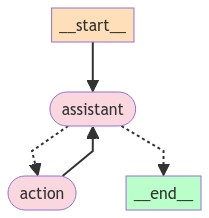

In [ ]:
from IPython.display import Image, display

try:
    display(Image(part_1_graph.get_graph(xray=True).draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

## Example Conversation


In [ ]:
import shutil
import uuid


# Update with the backup file so we can restart from the original place in each section
shutil.copy(backup_file, db)
thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        # The passenger_id is used in our flight tools to
        # fetch the user's flight information
        "passenger_id": "3442 587242",
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}

_printed = set()
for question in tutorial_questions:
    divider("Start")

    question_en = llm_translate_fa_to_en(question)

    events = part_1_graph.stream(
        {"messages": ("user", question_en)}, config, stream_mode="values"
    )

    event_messages = []
    for event in events:
        _print_event(event, _printed)
        event_messages.append(event.get("messages"))

    final_response = event_messages[-1][-1].content

    response_fa = llm_translate_en_to_fa(final_response)
    divider("Finish")


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



================================ Start =================================


================================ Translated To English =================================



Translated Text: What is the departure time of my flight?
================================ Human Message =================================

What is the departure time of my flight?
================================== Ai Message ==================================
Tool Calls:
  fetch_user_flight_information (call_nm0k0WzupFhuuqaaH0NqkwVO)
 Call ID: call_nm0k0WzupFhuuqaaH0NqkwVO
  Args:
================================= Tool Message =================================
Name: fetch_user_flight_information

[{"ticket_no": "7240005432906569", "book_ref": "C46E9F", "flight_id": 19250, "flight_no": "LX0112", "departure_airport": "CDG", "arrival_airport": "BSL", "scheduled_departure": "2024-04-30 12:09:03.561731-04:00", "scheduled_arrival": "2024-04-30 13:39:03.561731-04:00", "seat_no": "18E", "fare_conditions": "Economy"}]


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


================================== Ai Message ==================================

Your flight LX0112 is scheduled to depart from Charles de Gaulle Airport (CDG) to EuroAirport Basel Mulhouse Freiburg (BSL) on April 30, 2024, at 12:09 PM local time.

================================ Translated To Persian =================================

Original Text: Your flight LX0112 is scheduled to depart from Charles de Gaulle Airport (CDG) to EuroAirport Basel Mulhouse Freiburg (BSL) on April 30, 2024, at 12:09 PM local time.


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



================================ Finish =================================


================================ Start =================================


================================ Translated To English =================================



Translated Text: Do I have permission to change my flight schedule to an earlier time? I want to leave later today.
================================ Human Message =================================

Do I have permission to change my flight schedule to an earlier time? I want to leave later today.
================================== Ai Message ==================================
Tool Calls:
  lookup_policy (call_NTdCW30SFmNoBZcMVJ4lXYYO)
 Call ID: call_NTdCW30SFmNoBZcMVJ4lXYYO
  Args:
    query: flight change
================================= Tool Message =================================
Name: lookup_policy


## Booking and Cancellation

1. How can I change my booking?
	* The ticket number must start with 724 (SWISS ticket no./plate).
	* The ticket was not paid for by barter or voucher (there are exceptions to voucher payments; if the ticket was paid for in full by voucher, then it may be possible to rebook online under certain circumstances. If it is not possible to rebook online because

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


================================== Ai Message ==================================

Yes, you have permission to change your flight schedule to an earlier time, subject to certain conditions outlined by Swiss Airlines' policies. Here are the key points you should consider for changing your flight:

- Your ticket must start with 724, indicating it's a Swiss ticket.
- The change must involve an active flight booking; it's not possible to rebook open tickets or tickets without corresponding flight segments online.
- You can change the flight and the travel dates, but changes to the origin, destination, or passenger names are not possible online.
- Changes will apply to all passengers traveling together on the same booking.
- If you are departing from a Swiss airport, you can rebook online up to three hours before departure.
- Your seat reservation and special meal requests will be included in the rebooking.
- You will be given a new ticket number after rebooking, but your booking reference w

KeyboardInterrupt: 

# Part 2: Add Confirmation

## State & Assistant


In [ ]:
from typing import Annotated

from langchain_openai import ChatOpenAI
from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig
from typing_extensions import TypedDict

from langgraph.graph.message import AnyMessage, add_messages


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    user_info: str


class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            passenger_id = config.get("passenger_id", None)
            result = self.runnable.invoke(state)
            # If the LLM happens to return an empty response, we will re-prompt it
            # for an actual response.
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}


# Haiku is faster and cheaper, but less accurate
# llm = ChatAnthropic(model="claude-3-haiku-20240307")
# llm = ChatAnthropic(model="claude-3-sonnet-20240229", temperature=1)
# You could also use OpenAI or another model, though you will likely have
# to adapt the prompts

llm = ChatOpenAI(model="gpt-4-turbo-preview")

assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful customer support assistant for Swiss Airlines. "
            " Use the provided tools to search for flights, company policies, and other information to assist the user's queries. "
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            " If a search comes up empty, expand your search before giving up."
            "\n\nCurrent user:\n\n{user_info}\n"
            "\nCurrent time: {time}.",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now())

part_2_tools = [
    TavilySearchResults(max_results=1),
    fetch_user_flight_information,
    search_flights,
    lookup_policy,
    update_ticket_to_new_flight,
    cancel_ticket,
    search_car_rentals,
    book_car_rental,
    update_car_rental,
    cancel_car_rental,
    search_hotels,
    book_hotel,
    update_hotel,
    cancel_hotel,
    search_trip_recommendations,
    book_excursion,
    update_excursion,
    cancel_excursion,
]
part_2_assistant_runnable = assistant_prompt | llm.bind_tools(part_2_tools)

## Define Graph


In [ ]:
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import END, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition

builder = StateGraph(State)


def user_info(state: State):
    return {"user_info": fetch_user_flight_information.invoke({})}


# NEW: The fetch_user_info node runs first, meaning our assistant can see the user's flight information without
# having to take an action
builder.add_node("fetch_user_info", user_info)
builder.set_entry_point("fetch_user_info")
builder.add_node("assistant", Assistant(part_2_assistant_runnable))
builder.add_node("action", create_tool_node_with_fallback(part_2_tools))
builder.add_edge("fetch_user_info", "assistant")
builder.add_conditional_edges(
    "assistant", tools_condition, {"action": "action", END: END}
)
builder.add_edge("action", "assistant")

memory = SqliteSaver.from_conn_string(":memory:")
part_2_graph = builder.compile(
    checkpointer=memory,
    # NEW: The graph will always halt before executing the "action" node.
    # The user can approve or reject (or even alter the request) before
    # the assistant continues
    interrupt_before=["action"],
)

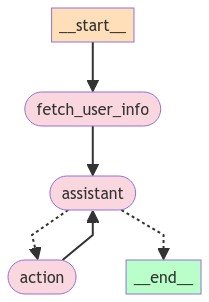

In [ ]:
from IPython.display import Image, display

try:
    display(Image(part_2_graph.get_graph(xray=True).draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

## Example Conversation


In [ ]:
import shutil
import uuid

# Update with the backup file so we can restart from the original place in each section
shutil.copy(backup_file, db)
thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        # The passenger_id is used in our flight tools to
        # fetch the user's flight information
        "passenger_id": "3442 587242",
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}


_printed = set()
# We can reuse the tutorial questions from part 1 to see how it does.
for question in tutorial_questions:
# while True:
#     question = input()
    events = part_2_graph.stream(
        {"messages": ("user", question)}, config, stream_mode="values"
    )

    for event in events:
        _print_event(event, _printed)

    snapshot = part_2_graph.get_state(config)
    while snapshot.next:
        _print_event(snapshot.values, _printed)
        # We have an interrupt! The agent is
        # trying to use a tool.
        # The user can approve or deny it
        user_input = input(
            "Do you approve of the above actions? Type 'y' to continue;"
            " otherwise, explain your requested changed.\n\n"
        )
        if user_input.strip() == "y":
            # Just continue
            result = part_2_graph.invoke(
                None,
                config,
            )
        else:
            # Satisfy the tool invocation by
            # providing instructions on the requested changes / change of mind
            result = part_2_graph.invoke(
                {
                    "messages": [
                        ToolMessage(
                            tool_call_id=event["messages"][-1].tool_calls[0]["id"],
                            content=f"API call denied by user. Reasoning: '{user_input}'. Continue assisting, accounting for the user's input.",
                        )
                    ]
                },
                config,
            )
        snapshot = part_2_graph.get_state(config)
        _print_event(snapshot.values, _printed)

Hi there, what time is my flight?
================================ Human Message =================================

Hi there, what time is my flight?
================================== Ai Message ==================================
Tool Calls:
  fetch_user_flight_information (call_l6iGFMmEE1PU38jqjwIAJ2K9)
 Call ID: call_l6iGFMmEE1PU38jqjwIAJ2K9
  Args:
Do you approve of the above actions? Type 'y' to continue; otherwise, explain your requested changed.

y
================================== Ai Message ==================================

Your flight LX0112 is scheduled to depart from CDG (Charles de Gaulle Airport) on April 30, 2024, at 12:09 PM local time and arrive at BSL (EuroAirport Basel Mulhouse Freiburg) on the same day at 1:39 PM local time. Your seat number is 18E, and you're flying Economy class. Is there anything else I can help you with?
Am i allowed to update my flight to something sooner? I want to leave later today.
================================ Human Message ==========

KeyboardInterrupt: Interrupted by user

In [ ]:
import shutil
import uuid

# Update with the backup file so we can restart from the original place in each section
shutil.copy(backup_file, db)
thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        # The passenger_id is used in our flight tools to
        # fetch the user's flight information
        "passenger_id": "3442 587242",
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}


_printed = set()
# We can reuse the tutorial questions from part 1 to see how it does.
for question in tutorial_questions:
    divider("Start")

    question_en = llm_translate_fa_to_en(question)

    events = part_2_graph.stream(
        {"messages": ("user", question_en)}, config, stream_mode="values"
    )

    event_messages = []
    for event in events:
        _print_event(event, _printed)
        event_messages.append(event.get("messages"))

    final_response = event_messages[-1][-1].content

    response_fa = llm_translate_en_to_fa(final_response)

    snapshot = part_2_graph.get_state(config)
    while snapshot.next:
        # We have an interrupt! The agent is
        # trying to use a tool.
        # The user can approve or deny it
        user_input = input(
            "آیا اقدامات بالا را تایید می‌کنید؟? برای تایید 'y' را وارد کنید،"
            " در غیر این صورت, تغییرات درخواستی خود را توضیح دهید.\n\n"
        )
        if user_input.strip() == "y":
            # Just continue
            result = part_2_graph.invoke(
                None,
                config,
            )
        else:
            user_input_en = llm_translate_fa_to_en(user_input)
            # Satisfy the tool invocation by
            # providing instructions on the requested changes / change of mind
            result = part_2_graph.invoke(
                {
                    "messages": [
                        ToolMessage(
                            tool_call_id=event["messages"][-1].tool_calls[0]["id"],
                            content=f"API call denied by user. Reasoning: '{user_input_en}'. Continue assisting, accounting for the user's input.",
                        )
                    ]
                },
                config,
            )
        snapshot = part_2_graph.get_state(config)
    divider("Finish")

KeyboardInterrupt: Interrupted by user

# Part 3: Conditional Interrupt

## State

In [ ]:
from typing import Annotated

from langchain_openai import ChatOpenAI
from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig
from typing_extensions import TypedDict

from langgraph.graph.message import AnyMessage, add_messages


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    user_info: str


class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            passenger_id = config.get("passenger_id", None)
            result = self.runnable.invoke(state)
            # If the LLM happens to return an empty response, we will re-prompt it
            # for an actual response.
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}


# Haiku is faster and cheaper, but less accurate
# llm = ChatAnthropic(model="claude-3-haiku-20240307")
# llm = ChatAnthropic(model="claude-3-sonnet-20240229", temperature=1)
# You can update the LLMs, though you may need to update the prompts

llm = ChatOpenAI(model="gpt-4-turbo-preview")

assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful customer support assistant for Swiss Airlines. "
            " Use the provided tools to search for flights, company policies, and other information to assist the user's queries. "
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            " If a search comes up empty, expand your search before giving up."
            "\n\nCurrent user:\n\n{user_info}\n"
            "\nCurrent time: {time}.",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now())


# "Read"-only tools (such as retrievers) don't need a user confirmation to use
part_3_safe_tools = [
    TavilySearchResults(max_results=1),
    fetch_user_flight_information,
    search_flights,
    lookup_policy,
    search_car_rentals,
    search_hotels,
    search_trip_recommendations,
]

# These tools all change the user's reservations.
# The user has the right to control what decisions are made
part_3_sensitive_tools = [
    update_ticket_to_new_flight,
    cancel_ticket,
    book_car_rental,
    update_car_rental,
    cancel_car_rental,
    book_hotel,
    update_hotel,
    cancel_hotel,
    book_excursion,
    update_excursion,
    cancel_excursion,
]
sensitive_tool_names = {t.name for t in part_3_sensitive_tools}
# Our LLM doesn't have to know which nodes it has to route to. In its 'mind', it's just invoking functions.
part_3_assistant_runnable = assistant_prompt | llm.bind_tools(
    part_3_safe_tools + part_3_sensitive_tools
)

## Define Graph

In [ ]:
from typing import Literal

from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import END, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition

builder = StateGraph(State)


def user_info(state: State):
    return {"user_info": fetch_user_flight_information.invoke({})}


# NEW: The fetch_user_info node runs first, meaning our assistant can see the user's flight information without
# having to take an action
builder.add_node("fetch_user_info", user_info)
builder.set_entry_point("fetch_user_info")
builder.add_node("assistant", Assistant(part_3_assistant_runnable))
builder.add_node("safe_tools", create_tool_node_with_fallback(part_3_safe_tools))
builder.add_node(
    "sensitive_tools", create_tool_node_with_fallback(part_3_sensitive_tools)
)
# Define logic
builder.add_edge("fetch_user_info", "assistant")


def route_tools(state: State) -> Literal["safe_tools", "sensitive_tools", "__end__"]:
    next_node = tools_condition(state)
    # If no tools are invoked, return to the user
    if next_node == END:
        return END
    ai_message = state["messages"][-1]
    # This assumes single tool calls. To handle parallel tool calling, you'd want to
    # use an ANY condition
    first_tool_call = ai_message.tool_calls[0]
    if first_tool_call["name"] in sensitive_tool_names:
        return "sensitive_tools"
    return "safe_tools"


builder.add_conditional_edges(
    "assistant",
    route_tools,
)
builder.add_edge("safe_tools", "assistant")
builder.add_edge("sensitive_tools", "assistant")

memory = SqliteSaver.from_conn_string(":memory:")
part_3_graph = builder.compile(
    checkpointer=memory,
    # NEW: The graph will always halt before executing the "action" node.
    # The user can approve or reject (or even alter the request) before
    # the assistant continues
    interrupt_before=["sensitive_tools"],
)

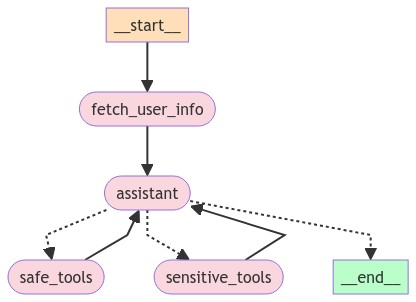

In [ ]:
from IPython.display import Image, display

try:
    display(Image(part_3_graph.get_graph(xray=True).draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

## Example Conversation

In [ ]:
import shutil
import uuid

# Update with the backup file so we can restart from the original place in each section
shutil.copy(backup_file, db)
thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        # The passenger_id is used in our flight tools to
        # fetch the user's flight information
        "passenger_id": "3442 587242",
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}

tutorial_questions = [
    "Hi there, what time is my flight?",
    "Am i allowed to update my flight to something sooner? I want to leave later today.",
    "Update my flight to sometime next week then",
    "The next available option is great",
    "what about lodging and transportation?",
    "Yeah i think i'd like an affordable hotel for my week-long stay (7 days). And I'll want to rent a car.",
    "OK could you place a reservation for your recommended hotel? It sounds nice.",
    "yes go ahead and book anything that's moderate expense and has availability.",
    "Now for a car, what are my options?",
    "Awesome let's just get the cheapest option. Go ahead and book for 7 days",
    "Cool so now what recommendations do you have on excursions?",
    "Are they available while I'm there?",
    "interesting - i like the museums, what options are there? ",
    "OK great pick one and book it for my second day there.",
]

tutorial_questions = [
    "سلام، ساعت پرواز من چه زمانی است؟",
    "آیا امکان تغییر پروازم به زمانی زودتر وجود دارد؟ می‌خواهم امروز دیرتر بروم.",
    "پس پروازم را به زمانی در هفته آینده تغییر دهید",
    "گزینه بعدی موجود عالی است",
    "درباره اقامتگاه و حمل و نقل چطور؟",
    "بله، فکر می‌کنم دوست دارم یک هتل مقرون به صرفه برای اقامت هفت روزه‌ام داشته باشم (۷ روز). همچنین می‌خواهم یک ماشین کرایه کنم.",
    "خوب، می‌توانید برای هتل توصیه شده توسط شما رزرو قرار دهید؟ به نظر خوب می‌رسد.",
    "بله، پیش بروید و هر چیزی که هزینه معقول دارد و موجود است را رزرو کنید.",
    "حالا برای ماشین، گزینه‌های من چه هستند؟",
    "عالی، بیایید گزینه ارزان‌ترین را انتخاب کنیم. پیش بروید و برای ۷ روز رزرو کنید",
    "خوبه، حالا چه پیشنهاداتی برای گشت‌ها دارید؟",
    "آیا آن‌ها در زمان حضور من در دسترس هستند؟",
    "جالب - من به موزه‌ها علاقه‌مندم، چه گزینه‌هایی وجود دارد؟",
    "خیلی خوب، یکی را انتخاب کنید و برای دومین روز اقامتم رزرو کنید.",
]


_printed = set()
# We can reuse the tutorial questions from part 1 to see how it does.
for question in tutorial_questions:
    question_en = llm_translate_fa_to_en(question, verbose=True)

    events = part_3_graph.stream(
        {"messages": ("user", question_en)}, config, stream_mode="values"
    )
    for event in events:
        _print_event(event, _printed)
    snapshot = part_3_graph.get_state(config)
    while snapshot.next:
        # We have an interrupt! The agent is
        # trying to use a tool.
        # The user can approve or deny it
        user_input = input(
            "آیا اقدامات بالا را تایید می‌کنید؟? برای تایید 'y' را وارد کنید،"
            " در غیر این صورت, تغییرات درخواستی خود را توضیح دهید.\n\n"
        )
        if user_input.strip() == "y":
            # Just continue
            result = part_3_graph.invoke(
                None,
                config,
            )
        else:
            user_input_en = llm_translate_fa_to_en(user_input, verbose=True)
            # Satisfy the tool invocation by
            # providing instructions on the requested changes / change of mind
            result = part_3_graph.invoke(
                {
                    "messages": [
                        ToolMessage(
                            tool_call_id=event["messages"][-1].tool_calls[0]["id"],
                            content=f"API call denied by user. Reasoning: '{user_input_en}'. Continue assisting, accounting for the user's input.",
                        )
                    ]
                },
                config,
            )
        snapshot = part_3_graph.get_state(config)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



================================ Translated To English =================================




Translated Text: What is the departure time of my flight?
================================ Human Message =================================

What is the departure time of my flight?
================================== Ai Message ==================================
Tool Calls:
  fetch_user_flight_information (call_GN8mnKlxyGk5lrdIWJPI802y)
 Call ID: call_GN8mnKlxyGk5lrdIWJPI802y
  Args:
================================= Tool Message =================================
Name: fetch_user_flight_information

[{"ticket_no": "7240005432906569", "book_ref": "C46E9F", "flight_id": 19250, "flight_no": "LX0112", "departure_airport": "CDG", "arrival_airport": "BSL", "scheduled_departure": "2024-04-30 12:09:03.561731-04:00", "scheduled_arrival": "2024-04-30 13:39:03.561731-04:00", "seat_no": "18E", "fare_conditions": "Economy"}]


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


================================== Ai Message ==================================

Your flight LX0112 is scheduled to depart from Charles de Gaulle Airport (CDG) on April 30, 2024, at 12:09 PM local time.

================================ Translated To English =================================




Translated Text: Is there a possibility of changing the flight to an earlier time? I want to go later today.
================================ Human Message =================================

Is there a possibility of changing the flight to an earlier time? I want to go later today.
================================== Ai Message ==================================
Tool Calls:
  search_flights (call_EA8ff7ANT9AFksqzwyD9YVfq)
 Call ID: call_EA8ff7ANT9AFksqzwyD9YVfq
  Args:
    departure_airport: CDG
    arrival_airport: BSL
    start_time: 2024-04-30T00:00:00-04:00
    end_time: 2024-04-30T23:59:59-04:00
    limit: 5
================================= Tool Message =================================
Name: search_flights

[{"flight_id": 19250, "flight_no": "LX0112", "scheduled_departure": "2024-04-30 12:09:03.561731-04:00", "scheduled_arrival": "2024-04-30 13:39:03.561731-04:00", "departure_airport": "CDG", "arrival_airport": "BSL", "status": "On Time", "aircraft_code": "SU9", "actual_departur

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


================================== Ai Message ==================================

It appears that for April 30, 2024, from Charles de Gaulle Airport (CDG) to EuroAirport Basel Mulhouse Freiburg (BSL), there is only one flight, which is the one you're already booked on: flight LX0112 departing at 12:09 PM.

Since you mentioned wanting to go later today but the date provided is April 30, 2024, let's clarify your request. Do you mean you want to find an earlier flight on a different date, specifically for today's date? If so, could you please confirm the current date from your perspective?

================================ Translated To English =================================




Translated Text: Please change my schedule to a time in the future this week.
================================ Human Message =================================

Please change my schedule to a time in the future this week.
================================== Ai Message ==================================
Tool Calls:
  search_flights (call_wWth8SFSbzf11iy9Svx0Wmma)
 Call ID: call_wWth8SFSbzf11iy9Svx0Wmma
  Args:
    arrival_airport: BSL
    departure_airport: CDG
    start_time: 2024-05-01T00:00:00-04:00
    end_time: 2024-05-07T23:59:59-04:00
    limit: 5
================================= Tool Message =================================
Name: search_flights

[{"flight_id": 19232, "flight_no": "LX0112", "scheduled_departure": "2024-05-04 12:09:03.561731-04:00", "scheduled_arrival": "2024-05-04 13:39:03.561731-04:00", "departure_airport": "CDG", "arrival_airport": "BSL", "status": "Scheduled", "aircraft_code": "SU9", "actual_departure": null, "actual_arrival": null}, {"flight_id": 19233, "fli

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


================================== Ai Message ==================================

Here are the available flights from Charles de Gaulle Airport (CDG) to EuroAirport Basel Mulhouse Freiburg (BSL) for the upcoming week:

1. **May 1, 2024**: Flight LX0112, Departure: 12:09 PM, Arrival: 1:39 PM
2. **May 3, 2024**: Flight LX0112, Departure: 12:09 PM, Arrival: 1:39 PM
3. **May 4, 2024**: Flight LX0112, Departure: 12:09 PM, Arrival: 1:39 PM
4. **May 6, 2024**: Flight LX0112, Departure: 12:09 PM, Arrival: 1:39 PM
5. **May 7, 2024**: Flight LX0112, Departure: 12:09 PM, Arrival: 1:39 PM

Please let me know which date you would prefer to reschedule your flight to.

================================ Translated To English =================================




Translated Text: The next option is excellent.
================================ Human Message =================================

The next option is excellent.
================================== Ai Message ==================================
Tool Calls:
  update_ticket_to_new_flight (call_biWCROgk7do9OjagkGaiWfCw)
 Call ID: call_biWCROgk7do9OjagkGaiWfCw
  Args:
    new_flight_id: 19233
    ticket_no: 7240005432906569
آیا اقدامات بالا را تایید می‌کنید؟? برای تایید 'y' را وارد کنید، در غیر این صورت, تغییرات درخواستی خود را توضیح دهید.

y


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



================================ Translated To English =================================




Translated Text: About Accommodation and Transportation How?
================================ Human Message =================================

About Accommodation and Transportation How?


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


================================== Ai Message ==================================

For accommodation and transportation, I can help you with booking hotels and car rentals in the destination city. Here's how we can proceed:

### Accommodation
I can search for hotels based on your preferences such as location, price tier (e.g., economy, midscale, upscale, luxury), and your check-in and check-out dates.

### Transportation
Similarly, for car rentals, I can find options based on location, car rental company, price tier, and the rental period.

Please provide me with more details on your preferences for both accommodation and transportation, such as:

- For hotels:
  - Preferred location (near an airport, city center, etc.)
  - Price tier
  - Check-in and check-out dates

- For car rentals:
  - Preferred pickup location
  - Car size or price tier
  - Pickup and drop-off dates

This information will help me find the best options for you.

================================ Translated To Englis


Translated Text: Yes, I think I would like to have a budget-friendly hotel for my 7-day stay. I also want to rent a car.
================================ Human Message =================================

Yes, I think I would like to have a budget-friendly hotel for my 7-day stay. I also want to rent a car.
================================== Ai Message ==================================
Tool Calls:
  search_hotels (call_8D852mF1DWNXPO1kaObjrwC1)
 Call ID: call_8D852mF1DWNXPO1kaObjrwC1
  Args:
    location: Basel
    price_tier: Economy
    checkin_date: 2024-05-03
    checkout_date: 2024-05-10
  search_car_rentals (call_E8I711tky3jsoJghcfMp5gny)
 Call ID: call_E8I711tky3jsoJghcfMp5gny
  Args:
    location: Basel
    price_tier: Economy
    start_date: 2024-05-03
    end_date: 2024-05-10
================================= Tool Message =================================
Name: search_car_rentals

[{"id": 1, "name": "Europcar", "location": "Basel", "price_tier": "Economy", "start_date": "2024

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


================================== Ai Message ==================================

Here are the options for your stay in Basel and car rental that match your preferences:

### Accommodation
Unfortunately, there are no hotels listed under the "Economy" price tier directly within the search results for your specified dates (May 3 to May 10, 2024) in Basel. However, here are options in other price tiers:
- **Hilton Basel**: Luxury
- **Hyatt Regency Basel**: Upper Upscale
- **Holiday Inn Basel**: Upper Midscale

### Car Rentals
For a budget-friendly option, there is one economy car rental available:
- **Europcar** in Basel

Would you like to book one of these hotels and proceed with the car rental from Europcar? If you're looking for a more budget-friendly hotel option, I can also assist with adjusting your criteria or exploring nearby areas.

================================ Translated To English =================================




Translated Text: Can you book the hotel recommended by you? It seems good.
================================ Human Message =================================

Can you book the hotel recommended by you? It seems good.
================================== Ai Message ==================================
Tool Calls:
  book_hotel (call_Bse7hJqX7dHVIqlKYY52dVlM)
 Call ID: call_Bse7hJqX7dHVIqlKYY52dVlM
  Args:
    hotel_id: 8
آیا اقدامات بالا را تایید می‌کنید؟? برای تایید 'y' را وارد کنید، در غیر این صورت, تغییرات درخواستی خود را توضیح دهید.

y


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



================================ Translated To English =================================




Translated Text: Yes, go ahead and book anything that has a reasonable cost and is available.
================================ Human Message =================================

Yes, go ahead and book anything that has a reasonable cost and is available.
================================== Ai Message ==================================
Tool Calls:
  book_car_rental (call_WcKZDQI8isNnUa7sxaRvhIMY)
 Call ID: call_WcKZDQI8isNnUa7sxaRvhIMY
  Args:
    rental_id: 1


# Other

In [ ]:
import bs4
from langchain import hub
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader, TelegramChatApiLoader
from langchain_community.vectorstores import Chroma
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_community.embeddings import HuggingFaceEmbeddings

In [ ]:
#### INDEXING ####

# Load Documents
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

# Split
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)

# Embed
# embedding = MistralAIEmbeddings()
embedding = HuggingFaceEmbeddings()
vectorstore = Chroma.from_documents(documents=splits,
                                    embedding=embedding)

retriever = vectorstore.as_retriever()

In [ ]:
#### RETRIEVAL and GENERATION ####

# Prompt
prompt = hub.pull("rlm/rag-prompt")

# LLM
# llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0, api_key='123')

# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Chain
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

# Question
result = rag_chain.invoke("نحوه پخت قرمه سبزی رو توضیح بده")

TypeError: Expected a Runnable, callable or dict.Instead got an unsupported type: <class 'str'>

In [ ]:
print(result)

Human: You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: نحوه پخت قرمه سبزی رو توضیح بده 
Context: 11. Delete file: "delete_file", args: "file": "<file>"
12. Search Files: "search_files", args: "directory": "<directory>"
13. Analyze Code: "analyze_code", args: "code": "<full_code_string>"
14. Get Improved Code: "improve_code", args: "suggestions": "<list_of_suggestions>", "code": "<full_code_string>"
15. Write Tests: "write_tests", args: "code": "<full_code_string>", "focus": "<list_of_focus_areas>"
16. Execute Python File: "execute_python_file", args: "file": "<file>"
17. Generate Image: "generate_image", args: "prompt": "<prompt>"
18. Send Tweet: "send_tweet", args: "text": "<text>"
19. Do Nothing: "do_nothing", args:
20. Task Complete (Shutdown): "task_complete", args: "reason": "<reason>